<a href="https://colab.research.google.com/github/sebasesto/CEIA/blob/master/VpC2/Clase_3_Tarea_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

Cuando realizamos Transfer Learning, tomamos un modelo ya entrenado con un conjunto de datos y utilizamos sus capas base para entrenar un nuevo modelo sobre otro dataset de interes. Dependiendo de la cantidad de datos y de lo diferentes que sean podremos evaluar como realizar dicho proceso de Transfer Learning.

Para este ejercicio, vamos a utilizar alguno de los modelos precargados en Keras para realizar Transfer Learning sobre el dataset de perros y gatos.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator



Podemos descargar el dataset al entorno de trabajo, desde una carpea de en Drive a partir de utilizar el ID del archivo dentro de Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/MyDrive/ColabNotebooks'

In [ ]:
!pip install kaggle

In [ ]:
# Navigate into Drive where you want to store your Kaggle data
os.chdir('/content/gdrive/MyDrive/ColabNotebooks')
# Check contents of directory, you should see the .zip file for the competition in your Drive
os.listdir()

['kaggle.json', 'fruits.zip']

In [ ]:
!kaggle datasets download -d moltean/fruits

fruits.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#!ls
os.listdir()

['kaggle.json', 'fruits.zip']

In [ ]:
#unzipping the zip files and deleting the zip files
!unzip /content/gdrive/MyDrive/ColabNotebooks/fruits.zip > /dev/null #/content/sample_data

In [ ]:
train_filename = '/content/gdrive/MyDrive/ColabNotebooks/fruits-360_dataset/fruits-360/Training'
val_filename = '/content/gdrive/MyDrive/ColabNotebooks/fruits-360_dataset/fruits-360/Test'

## Carga de datos con ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.7, 1.1],
                                   zoom_range=[0.7, 1.2],
                                   horizontal_flip=True,
                                   rescale=1./255)

valid_datagen = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.7, 1.1],
                                   zoom_range=[0.7, 1.2],
                                   horizontal_flip=True,
                                   rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory=train_filename,
                                                    target_size=(100, 100),
                                                    batch_size=32)

valid_generator = valid_datagen.flow_from_directory(directory=val_filename,
                                                    target_size=(100, 100),
                                                    batch_size=32)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [ ]:
classes = os.listdir(train_filename)
print(classes)

(100, 100, 3)


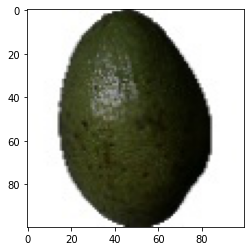

In [ ]:
#img = plt.imread('/content/gdrive/MyDrive/ColabNotebooks/fruits-360_dataset/fruits-360/Training/Apple Red 1/101_100.jpg')
img = plt.imread(train_filename+'/Avocado/103_100.jpg')
fig, rows = plt.subplots(nrows=1, ncols=1)
print(img.shape)
plt.imshow(img)
#plt.title(f"Example {c}")


## Carga de modelo base

Dentro de Keras, hay un modulo llamado [`applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=es-419), dentro del cual podemos encontrar algunos modelos de redes convolucionales, como los vistos en teoria, ya preentrenados y disponibles para descargar y utilizar. En este caso vamos a utilizar la arquitectura de VGG16 cuyos pesos fueron entrenados con el dataset ImageNet.

In [ ]:
vgg_base = tf.keras.applications.VGG16(weights='imagenet',
                                       include_top=False,
                                       input_shape=(100, 100, 3))

vgg_base.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                              

## Congelo las capas de la red base

El primer paso para realizar Transfer Learning seria congelar las capas del modelo base seleccionado. 

In [ ]:
vgg_base.trainable = False

Luego, agregamos las capas para armar el clasificador que querramos. En este caso, agregamos una capa de 512 neuronas y la salida con 2 unidades.

In [ ]:
model = tf.keras.Sequential()

model.add(vgg_base)

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(131, activation='softmax'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),    
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

history = model.fit(train_generator,
                    epochs=10,
                    validation_data=valid_generator)

Epoch 1/10
2116/2116 [==============================] - 566s 267ms/step - loss: 1.1767 - categorical_accuracy: 0.7770 - val_loss: 1.4858 - val_categorical_accuracy: 0.6836
Epoch 2/10
2116/2116 [==============================] - 568s 268ms/step - loss: 1.0107 - categorical_accuracy: 0.8057 - val_loss: 1.3407 - val_categorical_accuracy: 0.7054
Epoch 3/10
2116/2116 [==============================] - 573s 271ms/step - loss: 0.8814 - categorical_accuracy: 0.8316 - val_loss: 1.2311 - val_categorical_accuracy: 0.7243
Epoch 4/10
2116/2116 [==============================] - 577s 273ms/step - loss: 0.7812 - categorical_accuracy: 0.8488 - val_loss: 1.1393 - val_categorical_accuracy: 0.7369
Epoch 5/10
2116/2116 [==============================] - 560s 265ms/step - loss: 0.6936 - categorical_accuracy: 0.8659 - val_loss: 1.0627 - val_categorical_accuracy: 0.7515
Epoch 6/10
2116/2116 [==============================] - 574s 271ms/step - loss: 0.6312 - categorical_accuracy: 0.8757 - val_loss: 0.9993 - v

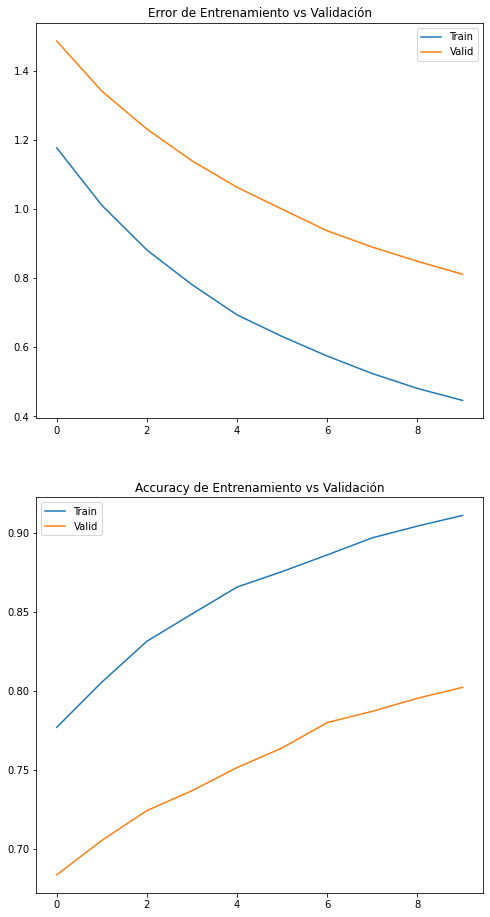

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8,16))

axs[0].plot(history.history['loss']) 
axs[0].plot(history.history['val_loss']) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history.history['categorical_accuracy']) 
axs[1].plot(history.history['val_categorical_accuracy']) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])